In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("test.csv", sep = ",")
data.head()

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,dq_W,dq_X,dq_Y,dq_Z,dv[1],...,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z,Mag_X,Mag_Y,Mag_Z,Status,Unnamed: 22
0,0,42099055,-12.721107,-28.800713,46.164322,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.602539,-0.828369,0,
1,1,42107388,-12.720507,-28.796194,46.171844,1.0,0.000037,0.000026,0.000065,0.041291,...,-2.056736,8.687750,0.506560,0.354027,0.891721,0.007812,0.605469,-0.827393,0,
2,2,42115721,-12.713481,-28.790560,46.176003,1.0,0.000079,0.000041,0.000042,0.041270,...,-2.027445,8.678981,1.083700,0.563603,0.575334,0.004883,0.603760,-0.827881,0,
3,3,42124054,-12.772911,-28.805216,46.112556,1.0,0.000096,0.000052,0.000053,0.041324,...,-1.993526,8.701675,1.314868,0.716033,0.726125,0.004639,0.602539,-0.825439,0,
4,4,42132387,-12.758975,-28.788996,46.119652,1.0,0.000151,0.000126,0.000084,0.041406,...,-1.952727,8.758675,2.082425,1.733866,1.157033,0.007080,0.603027,-0.819092,0,


In [3]:
ax = data["Acc_X"]
ay = data["Acc_Y"]
az = data["Acc_Z"]
gx = data["Gyr_X"]
gy = data["Gyr_Y"]
gz = data["Gyr_Z"]

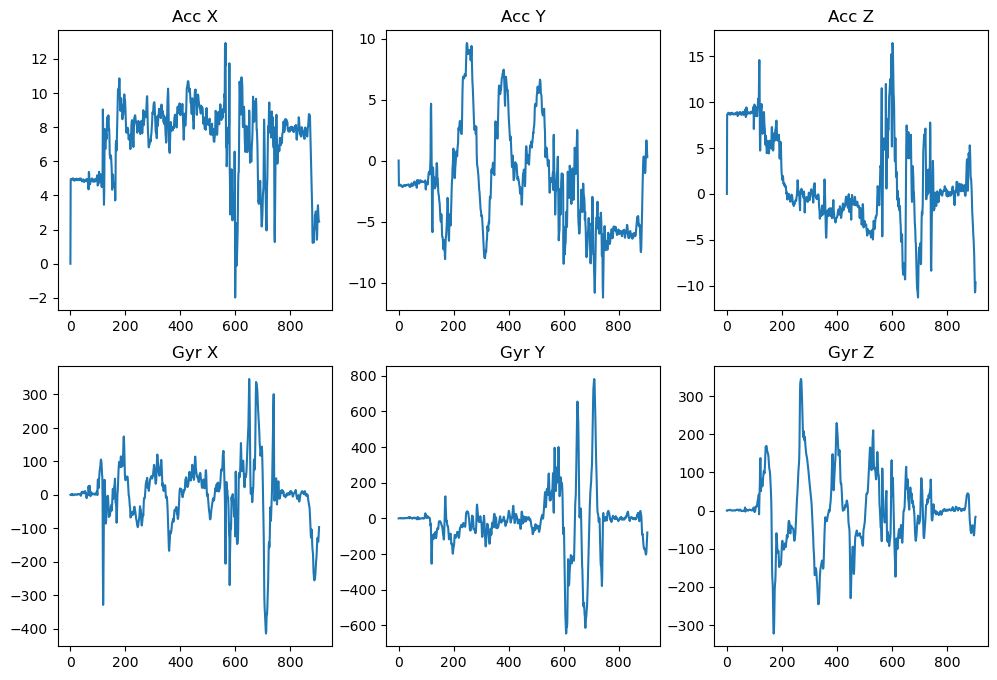

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)
axs[0, 0].plot(ax)
axs[0, 0].set_title('Acc X')
axs[0, 1].plot(ay)
axs[0, 1].set_title('Acc Y')
axs[0, 2].plot(az)
axs[0, 2].set_title('Acc Z')

axs[1, 0].plot(gx)
axs[1, 0].set_title('Gyr X')
axs[1, 1].plot(gy)
axs[1, 1].set_title('Gyr Y')
axs[1, 2].plot(gz)
axs[1, 2].set_title('Gyr Z')
plt.show()